<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw9/Homework9_ebm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 303 (delta 80), reused 66 (delta 55), pack-reused 163
Receiving objects: 100% (303/303), 54.18 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=24553 sha256=9054e6301aebb520db62d294045621865bdf19099a709e43397f5b7898b7d3e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsmk1_h8/wheels/55/59/29/0fb1c6356521577

In [2]:
from dul_2021.utils.hw9_utils import *
import numpy as np
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [16., 16.]

# Question 1: EBM on MNIST

Here we will implement EBM on MNIST data. 

* **Architecture.** You may experiment with different hyperparameters and architecture designs, but 
the following designs for the EBM architecture may be useful.

```
    Conv2d(1, 16, 5, 2, 4), 
    Swish(),
    Conv2d(16, 32, 3, 2, 1),
    Swish(), 
    Conv2d(32, 64, 3, 2, 1), 
    Swish(), 
    Conv2d(64, 64, 3, 2, 1), 
    Swish(),
    Flatten(),
    Linear(256, 64), 
    Swish(),
    Linear(64, 1)
```


Where `swish(x) = σ(x)x`. You **should** use activation with non-sparse gradients for better MCMC convergence.

* **Buffer.** To use the contrastive divergence objective, we need to generate samples during training. Because of high dimension of image space we need a lot of iterations in MCMC to obtain reasonable samples. We can reduce sampling cost with buffer trick. The idea of this trick it to re-use previous samples as starting points for MCMC (since distribuionts are close). In our implementation, we initialize 95% of starting points with previous samples and 5% with random noise from -1 to 1. 

* **MCMC.** During MCMC procedure you only need gradients wrt input. You can find it helpful to disable gradients of your model during MCMC. Since all images are in [-1, 1] you should clamp all resulting points during MCMC step. We also clamp gradients to [-0.03, 0.03].
    ```
    for p in model.parameters():
        p.requires_grad = False
    ```

* **Regularizations.**

 You should add small noise to real data otherwise ebm will focus on black areas of real images won't train.

 Add l2 regularaztion to ebm outputs on real and fake data. Otherwise, the output values will fluctuate in a very large range (because energy is invariant to scalar shift).

* **Hyperparameters**
    * Max buffer size - 8192
    * MCMC step size - 10
    * MCMC # step - 60
    * MCMC noise - N(0, 0.005)
    * Noise to data - N(0, 0.005)
    * l2 reg weight - 0.1
    * batch_size - 128
    * use Adam with lr=1e-3 and betas=(0, 0.999)
    * you can exponential scheduler
    * 20 epochs should be enough (~1 hour on gpu)



**You will provide the following deliverables**


1.   Over the course of training, record the regularization and contrastive losses per batch.
2. 100 samples from your trained EBM

## Convolutions for energy

In [152]:
class Energy(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(1, 16, 5, 2, 4),
                              nn.SiLU(),
                              nn.Conv2d(16, 32, 3, 2, 1),
                              nn.SiLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.SiLU(),
                              nn.Conv2d(64, 64, 3, 2, 1),
                              nn.SiLU())

    self.linear = nn.Sequential(nn.Flatten(),
                                nn.Linear(256, 64),
                                nn.SiLU(),
                                nn.Linear(64, 1))
    
  def forward(self, x):
    x = self.conv(x)
    return self.linear(x)

## Sampling

In [153]:
normal_std = 3e-2
std_deviced = torch.tensor(normal_std, device=device)
ε_deviced = torch.tensor(1., device=device)  # old value: 10 

def MCMC(model, x, steps=60, ε=ε_deviced, std=std_deviced):
  x.requires_grad = True
  grad_output = torch.ones((x.shape[0], 1), device=device)
  
  for _ in range(steps):
    
    # Градиентный шаг
    g = torch.autograd.grad(model(x), x,
                            grad_outputs=grad_output)[0]
    g = torch.clip(g, -3e-1, 3e-1)
    x = x + ε_deviced * g
    
    # Шум
    z = torch.randn(x.shape, device=device) * std
    x += torch.sqrt(2 * ε) * z
    x = torch.clip(x, -1, 1)

    #ε *= 0.9

  return x.detach()

## Buffer

In [17]:
def stop_grads(fn):
  def wrap(s, model, *args, **kwargs):
    for p in model.parameters():
      p.requires_grad = False
    
    output = fn(s, model, *args, **kwargs)

    for p in model.parameters():
      p.requires_grad = True

    return output

  return wrap

In [18]:
class Buffer:
  def __init__(self, size=8192, sample_size=(1, 28, 28)):
    self.size = size
    self.sample_size = sample_size
    self.samples = torch.rand((size, *sample_size), device=device) * 2 - 1
  
  @stop_grads
  def get_samples(self, model, batch_size=128, ratio=0.05):
    
    # Select from buffer
    idx = np.random.randint(0, self.size, size=batch_size)
    x = self.samples[idx]

    # Resample `ratio` examples
    resampled_size = int(ratio * batch_size)
    resampled_idx = np.random.randint(0, batch_size, resampled_size)
    x[resampled_idx] = torch.rand((resampled_size, *self.sample_size), device=device) * 2 - 1
    
    # Perform MCMC sampling and save results in buffer
    x = MCMC(model, x)
    self.samples[idx] = x

    return x

## Hyperparameters

In [156]:
num_epochs = 20
batch_size = 128
η = 1e-1

## Load data

In [157]:
from torch.utils.data import DataLoader

train_data, _ = get_mnist()
data = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## Define model

In [158]:
from torch.optim import Adam

E = Energy().to(device)
B = Buffer()

opt = Adam(E.parameters(), lr=1e-3, betas=(0, 0.999))

## Training loop

Iteration 100
	 contrastive = 172.23072389554
	 regularization = 796.6946784649044
Iteration 200
	 contrastive = 71.6454550921917
	 regularization = 347.31994104385376
Iteration 300
	 contrastive = 27.952936843037605
	 regularization = 139.58282619714737
Iteration 400
	 contrastive = 19.288386080414057
	 regularization = 94.88588774204254
Epoch : 1


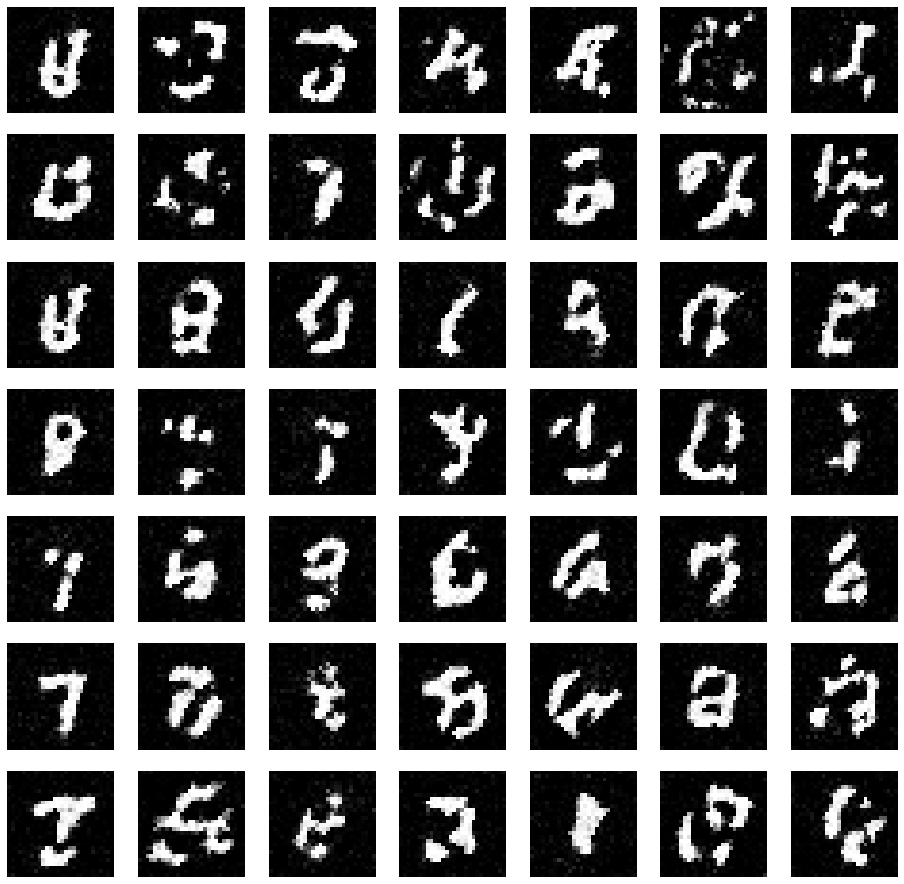

Iteration 100
	 contrastive = 21.297118574380875
	 regularization = 105.0714060664177
Iteration 200
	 contrastive = 20.4439669623971
	 regularization = 102.94220727682114
Iteration 300
	 contrastive = 19.039661213755608
	 regularization = 95.10812562704086
Iteration 400
	 contrastive = 17.520758483558893
	 regularization = 91.1232779622078
Epoch : 2


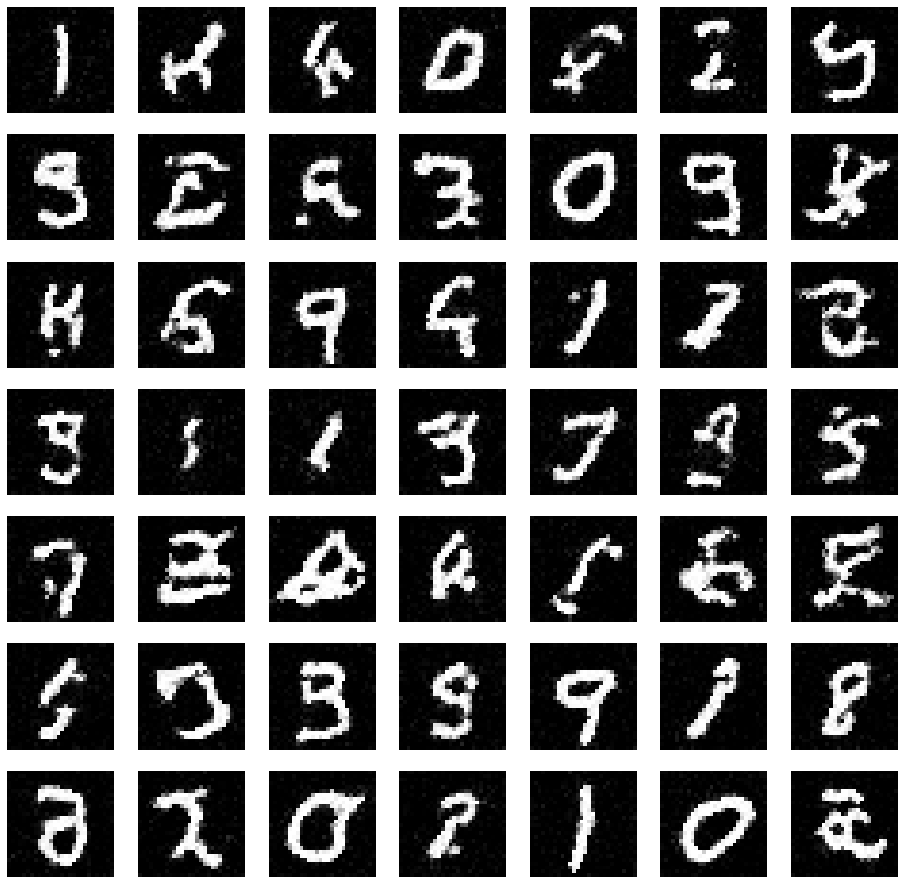

Iteration 100
	 contrastive = 14.763599969446659
	 regularization = 74.2038024365902
Iteration 200
	 contrastive = 12.988005015999079
	 regularization = 68.7429941445589
Iteration 300
	 contrastive = 12.55480077303946
	 regularization = 63.088622599840164
Iteration 400
	 contrastive = 12.290045741014183
	 regularization = 61.08413869142532
Epoch : 3


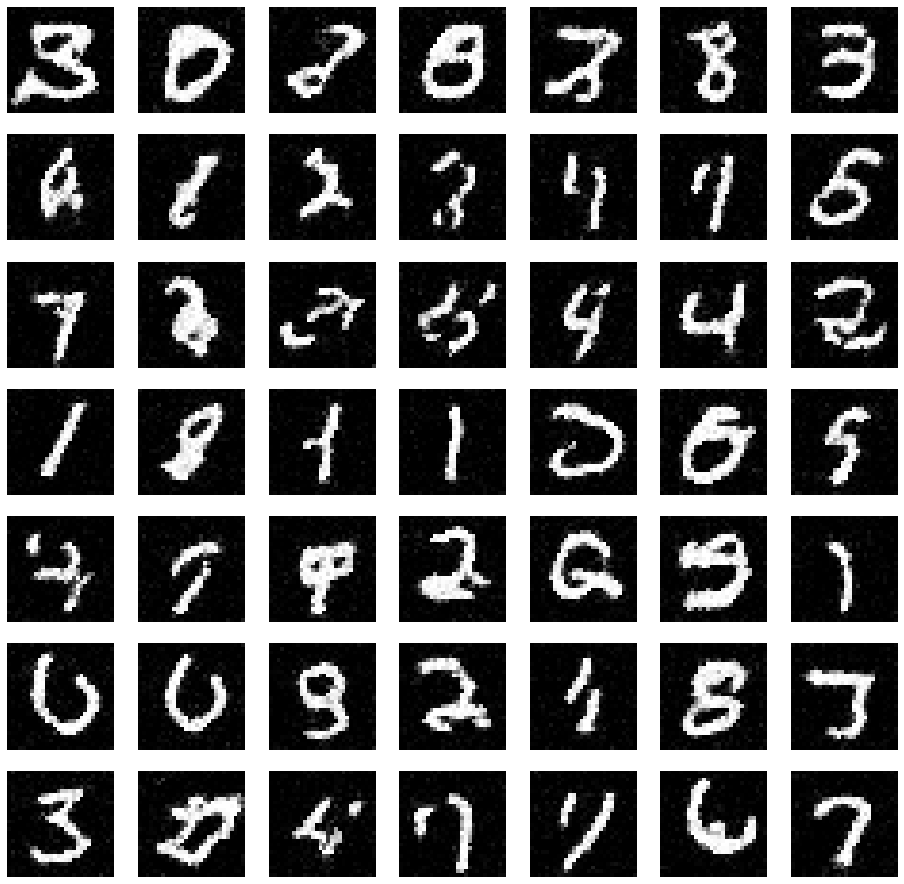

Iteration 100
	 contrastive = 11.112225810065866
	 regularization = 55.19297160208225
Iteration 200
	 contrastive = 10.981995673850179
	 regularization = 59.144959822297096
Iteration 300
	 contrastive = 11.014813443645835
	 regularization = 53.504699259996414
Iteration 400
	 contrastive = 10.356373650021851
	 regularization = 52.776788741350174
Epoch : 4


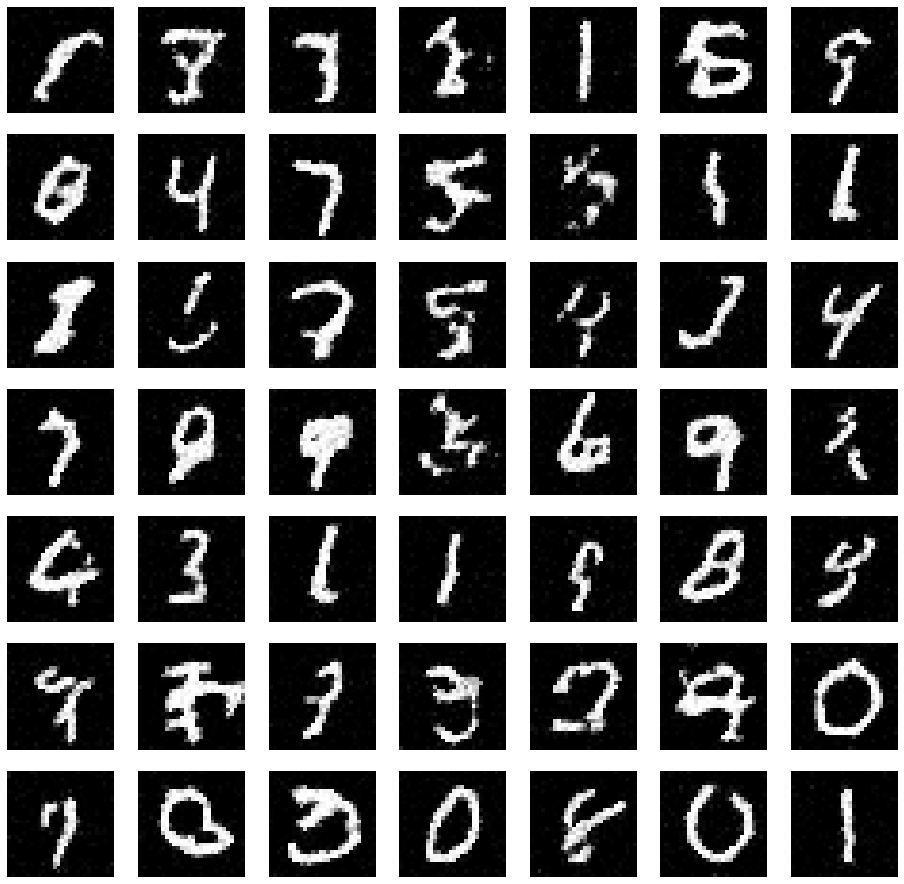

Iteration 100
	 contrastive = 10.5282823741436
	 regularization = 54.079165399074554
Iteration 200
	 contrastive = 9.689258454367518
	 regularization = 48.589125484228134
Iteration 300
	 contrastive = 9.74185395706445
	 regularization = 50.6203391328454
Iteration 400
	 contrastive = 10.603599632624537
	 regularization = 52.047961711883545
Epoch : 5


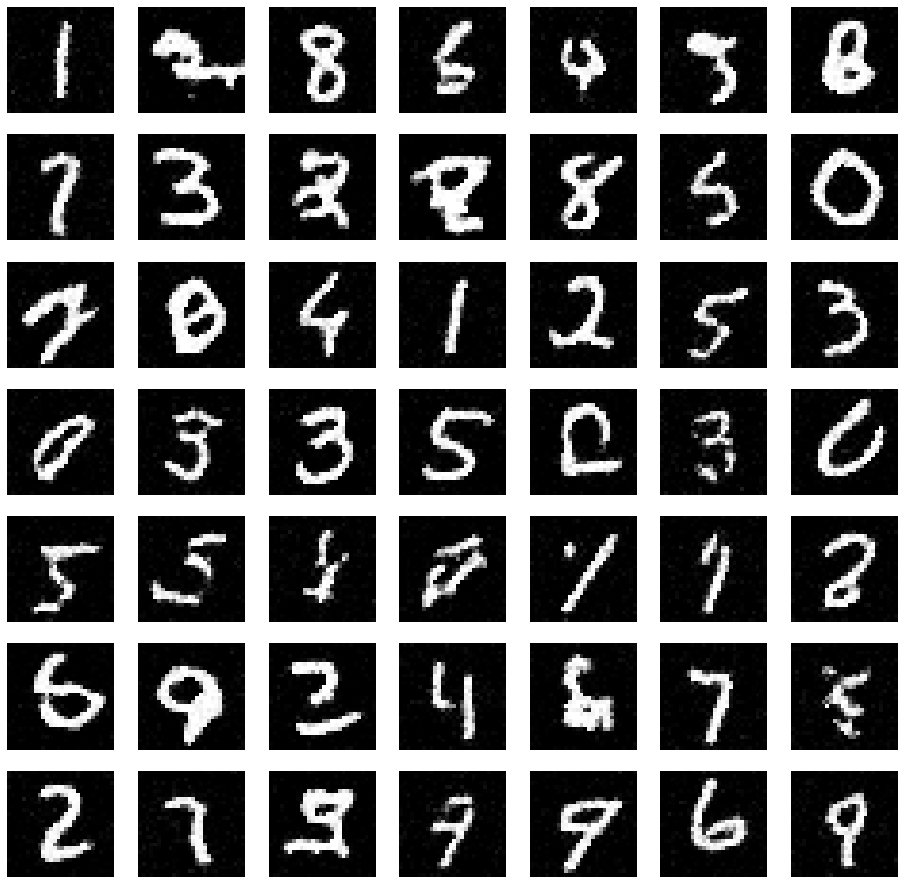

Iteration 100
	 contrastive = 10.21019307244569
	 regularization = 54.24583297967911
Iteration 200
	 contrastive = 10.01651765499264
	 regularization = 48.7994896620512
Iteration 300
	 contrastive = 10.32521095033735
	 regularization = 52.9809425920248
Iteration 400
	 contrastive = 10.146779756061733
	 regularization = 50.112807244062424
Epoch : 6


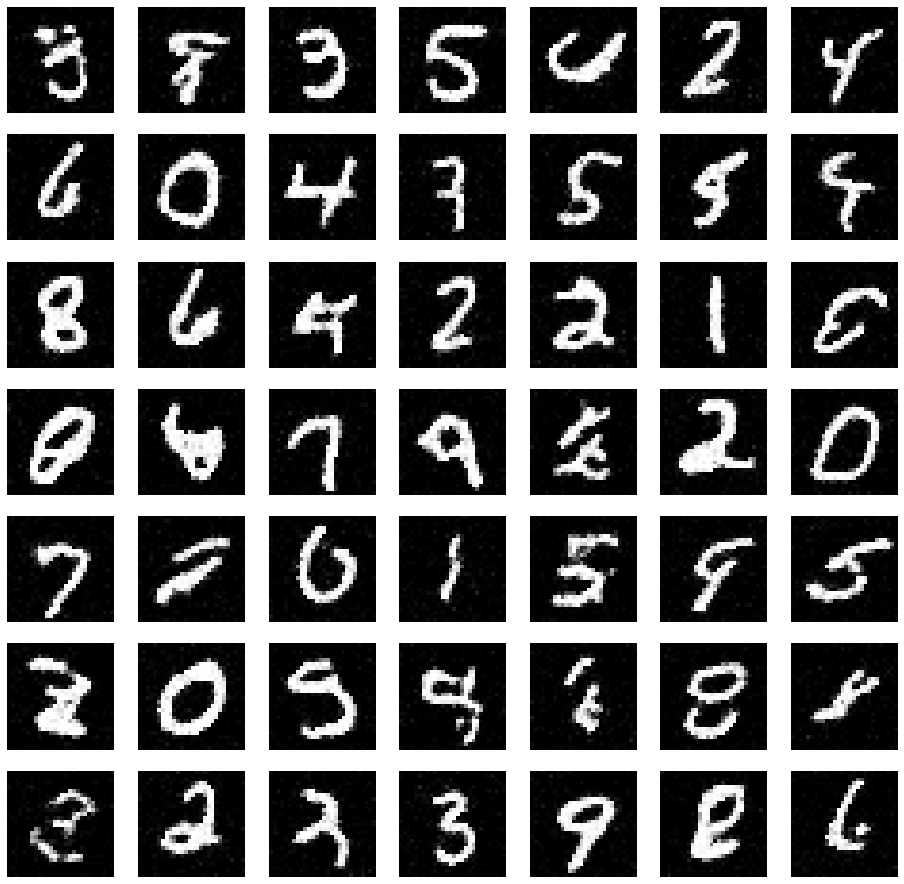

Iteration 100
	 contrastive = 9.370709100738168
	 regularization = 51.73294571042061
Iteration 200
	 contrastive = 10.744148096535355
	 regularization = 51.1261745095253
Iteration 300
	 contrastive = 9.326179690659046
	 regularization = 47.605353221297264
Iteration 400
	 contrastive = 9.859153609257191
	 regularization = 50.37692242860794
Epoch : 7


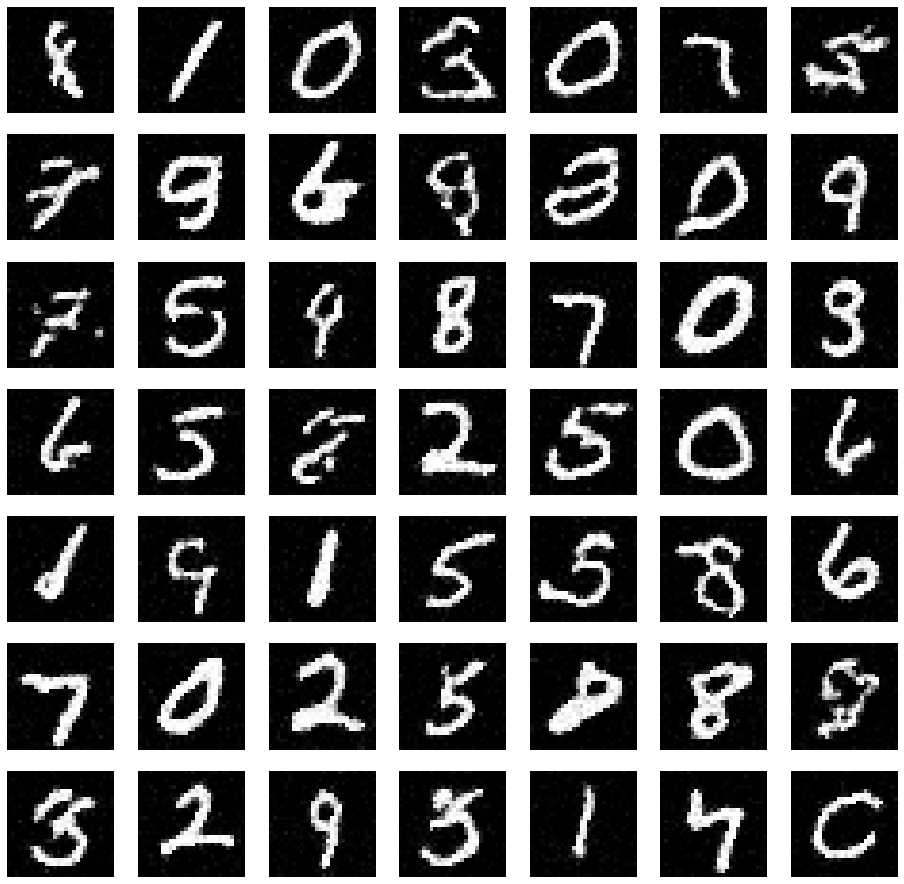

Iteration 100
	 contrastive = 10.20771263167262
	 regularization = 51.79929196834564
Iteration 200
	 contrastive = 9.44369602855295
	 regularization = 49.22407750785351
Iteration 300
	 contrastive = 9.70348435267806
	 regularization = 54.72312530875206
Iteration 400
	 contrastive = 10.737945904955268
	 regularization = 49.143016934394836
Epoch : 8


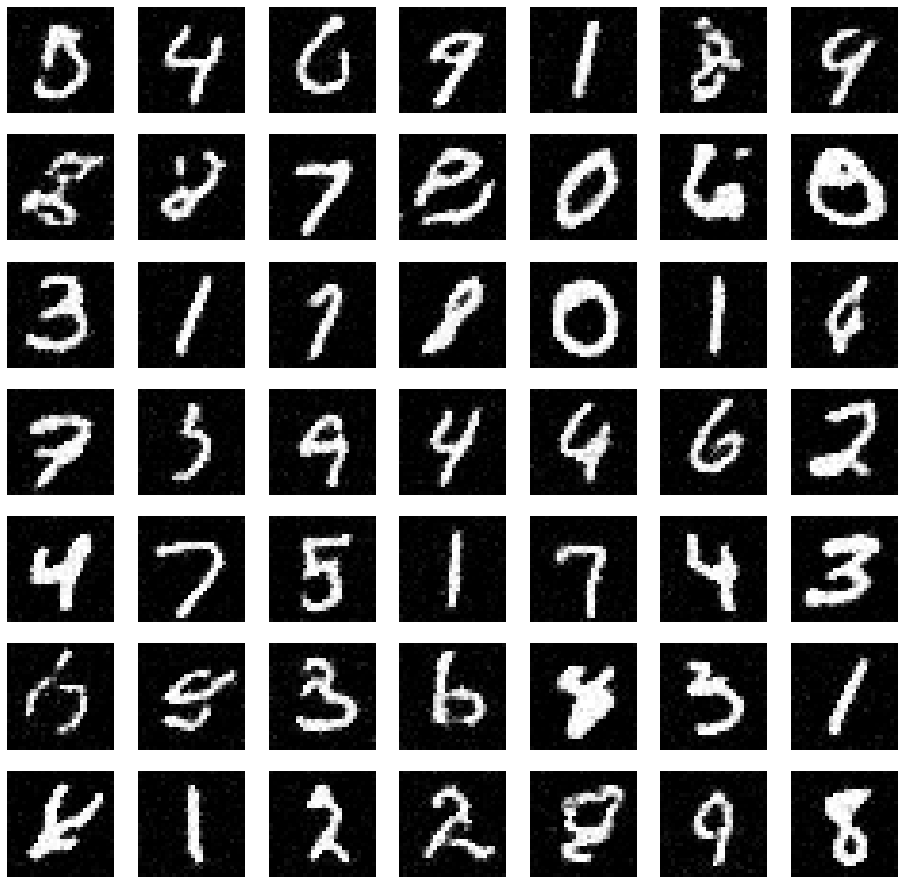

Iteration 100
	 contrastive = 11.28240894433111
	 regularization = 56.53634688258171
Iteration 200
	 contrastive = 9.392675202339888
	 regularization = 47.44665749371052
Iteration 300
	 contrastive = 9.13665887247771
	 regularization = 47.77327489852905
Iteration 400
	 contrastive = 9.876928527839482
	 regularization = 49.04009194672108
Epoch : 9


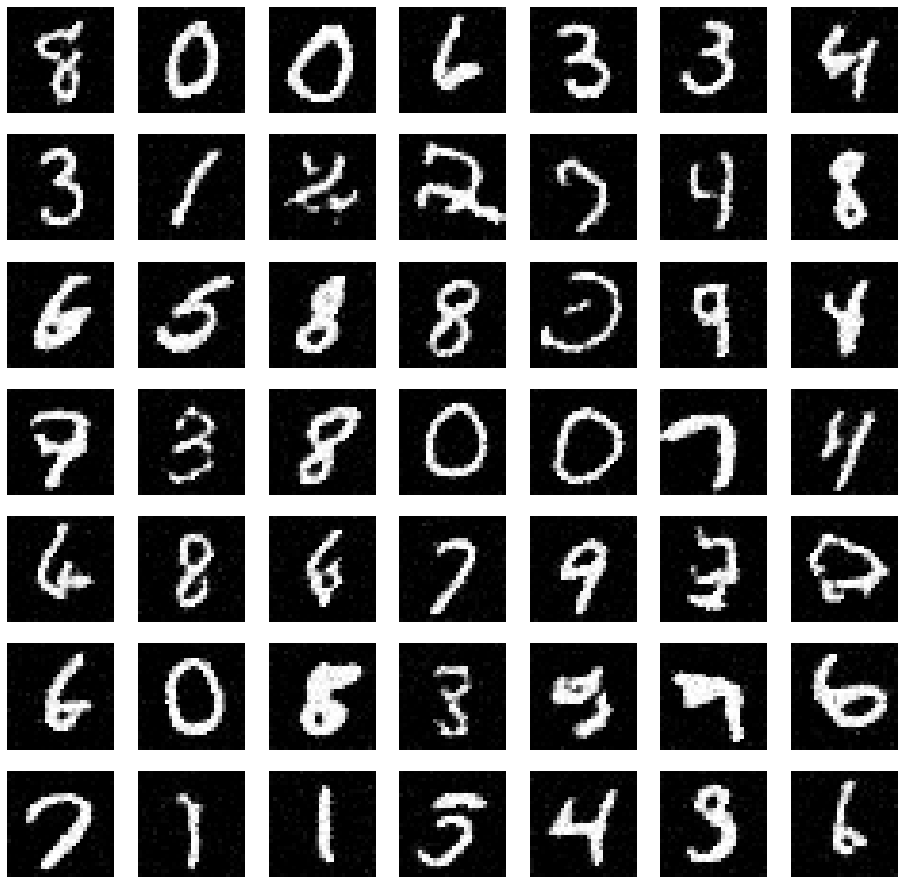

Iteration 100
	 contrastive = 9.829745013732463
	 regularization = 50.39595910906792
Iteration 200
	 contrastive = 9.95265291351825
	 regularization = 51.14877326786518
Iteration 300
	 contrastive = 8.615167314186692
	 regularization = 42.81545902788639
Iteration 400
	 contrastive = 9.287197723053396
	 regularization = 48.16050264239311
Epoch : 10


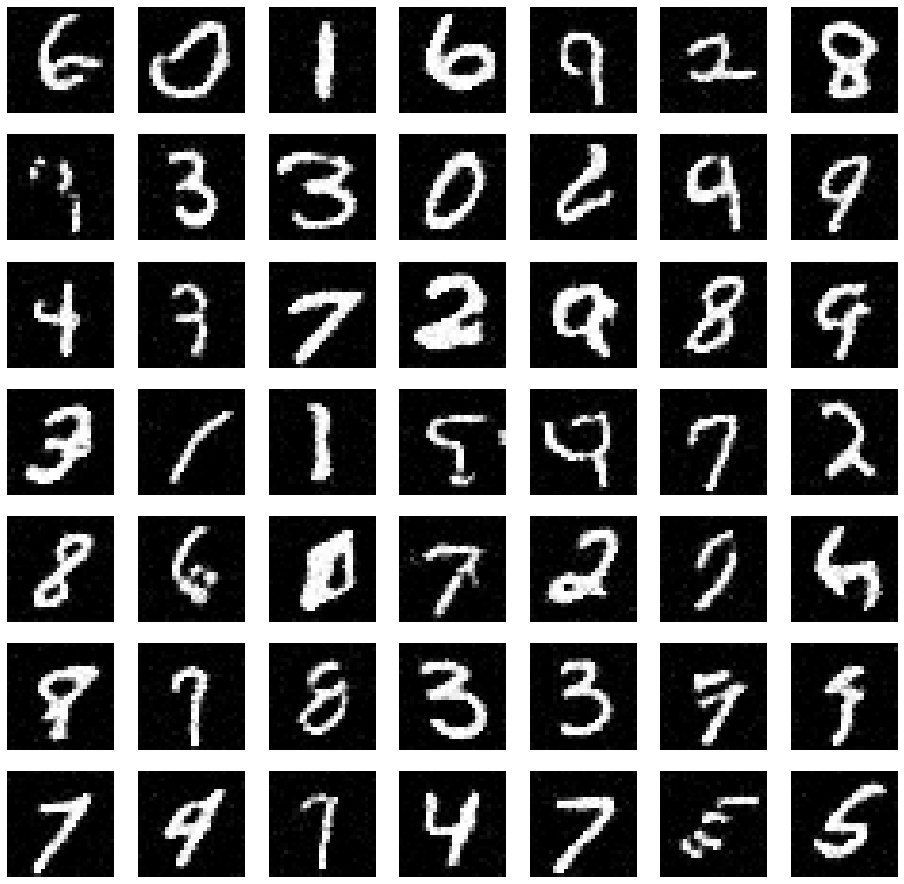

Iteration 100
	 contrastive = 9.398729460313916
	 regularization = 47.15577179193497
Iteration 200
	 contrastive = 10.042235695756972
	 regularization = 51.47771090269089
Iteration 300
	 contrastive = 8.60233187675476
	 regularization = 42.766317903995514
Iteration 400
	 contrastive = 9.261040557641536
	 regularization = 48.75671075284481
Epoch : 11


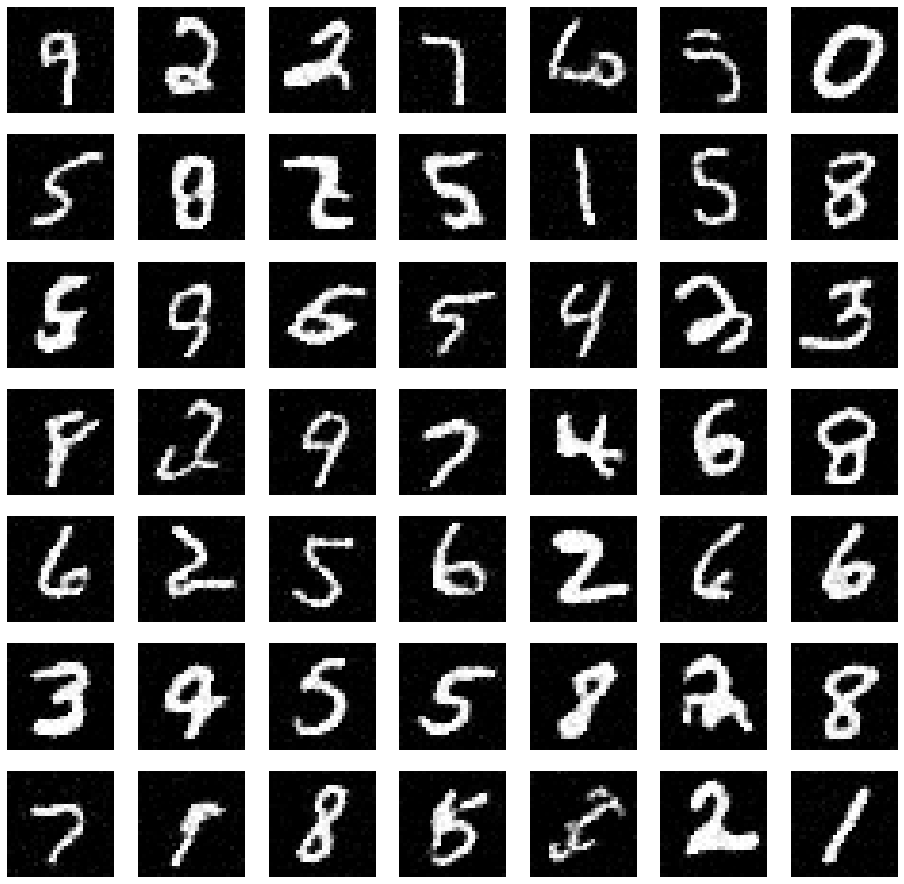

Iteration 100
	 contrastive = 9.731599535793066
	 regularization = 49.03226587176323
Iteration 200
	 contrastive = 10.790456859394908
	 regularization = 55.732885494828224
Iteration 300
	 contrastive = 9.37865115981549
	 regularization = 48.21678613126278
Iteration 400
	 contrastive = 10.125561220571399
	 regularization = 50.849913373589516
Epoch : 12


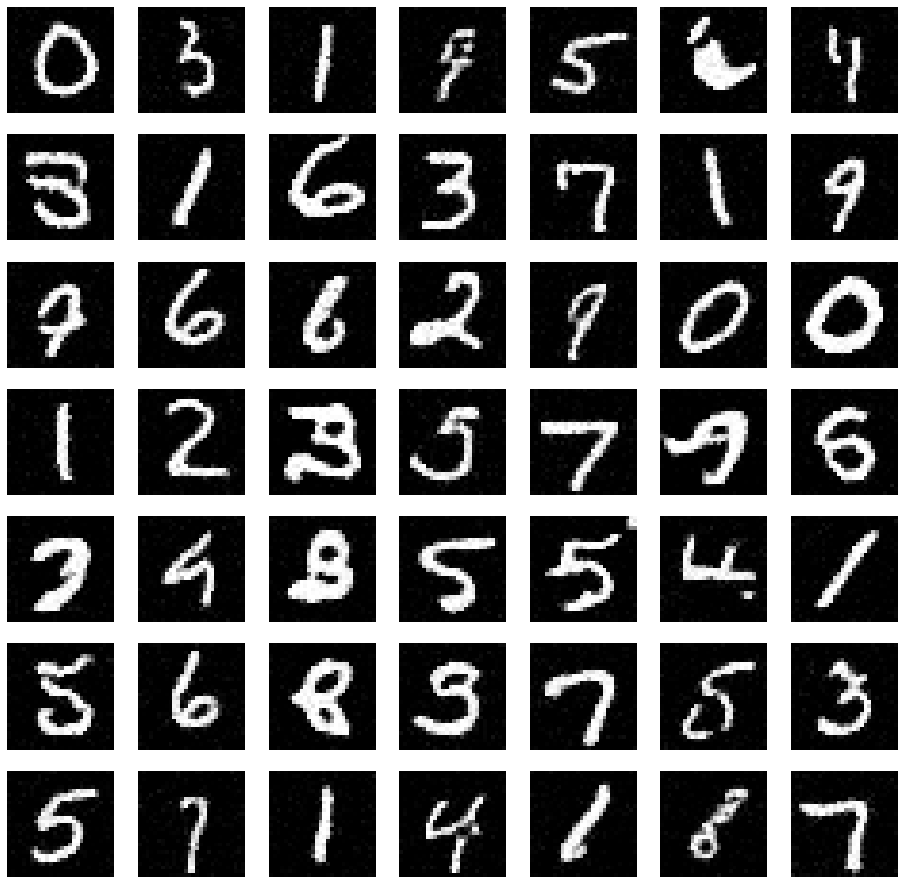

Iteration 100
	 contrastive = 9.386626641266048
	 regularization = 47.973796024918556
Iteration 200
	 contrastive = 9.126993064768612
	 regularization = 46.85634559392929
Iteration 300
	 contrastive = 9.364082426764071
	 regularization = 48.44458511471748
Iteration 400
	 contrastive = 9.675091648474336
	 regularization = 49.01375441253185
Epoch : 13


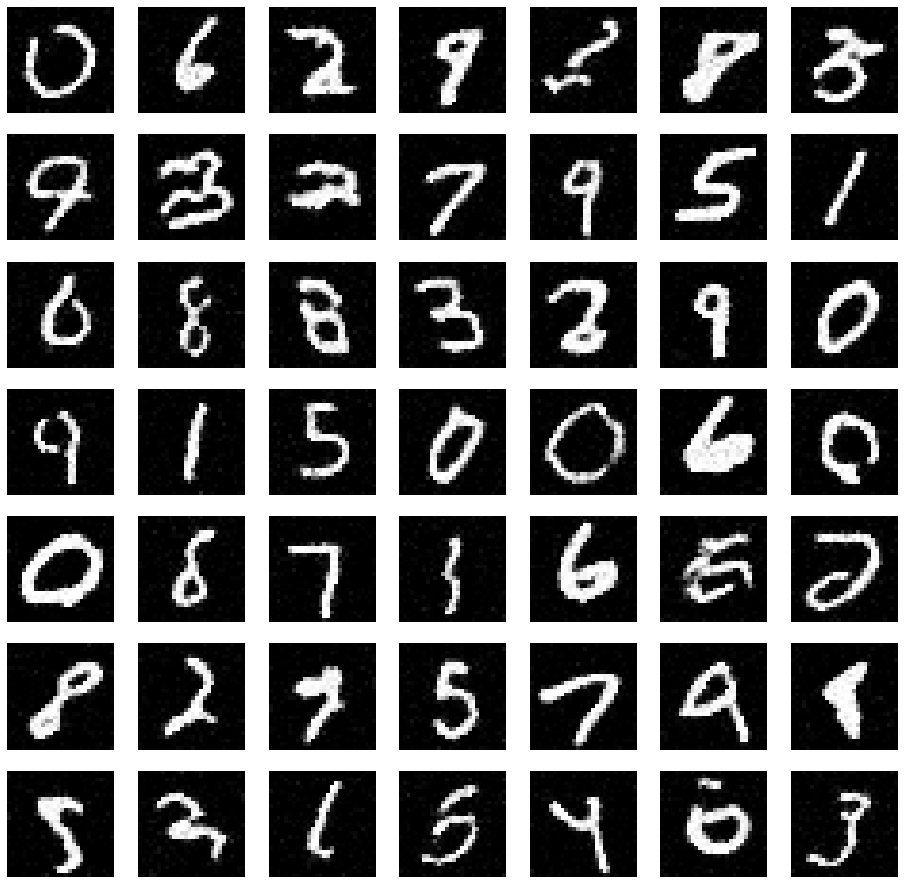

Iteration 100
	 contrastive = 9.386809453833848
	 regularization = 47.86146114766598
Iteration 200
	 contrastive = 9.96285298652947
	 regularization = 51.51920184493065
Iteration 300
	 contrastive = 9.108070231974125
	 regularization = 45.25129088759422
Iteration 400
	 contrastive = 10.031826522666961
	 regularization = 51.98594431579113
Epoch : 14


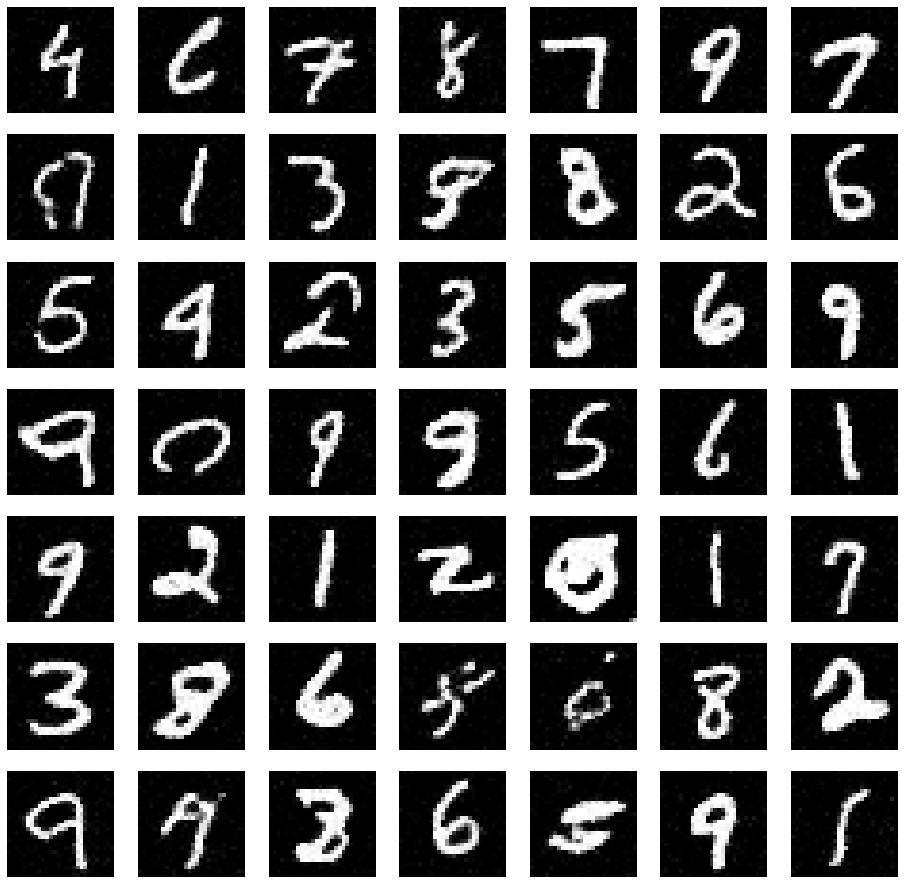

Iteration 100
	 contrastive = 9.300566919147968
	 regularization = 48.46927270293236
Iteration 200
	 contrastive = 9.579987186938524
	 regularization = 48.01218172907829
Iteration 300
	 contrastive = 8.919700670987368
	 regularization = 44.70883370935917
Iteration 400
	 contrastive = 9.461153998505324
	 regularization = 48.388855040073395
Epoch : 15


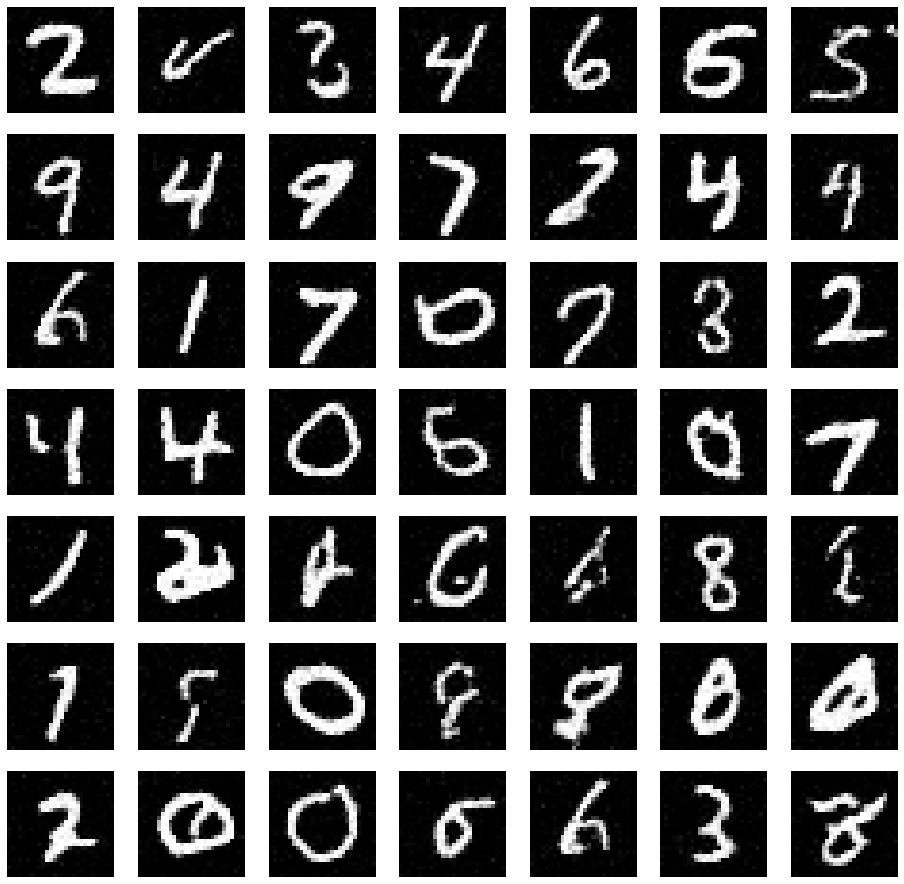

Iteration 100
	 contrastive = 9.558687495067716
	 regularization = 48.32747167348862
Iteration 200
	 contrastive = 10.072137394919991
	 regularization = 52.06249898672104
Iteration 300
	 contrastive = 9.999023581854999
	 regularization = 50.6313252300024
Iteration 400
	 contrastive = 10.29847760964185
	 regularization = 51.61720830202103
Epoch : 16


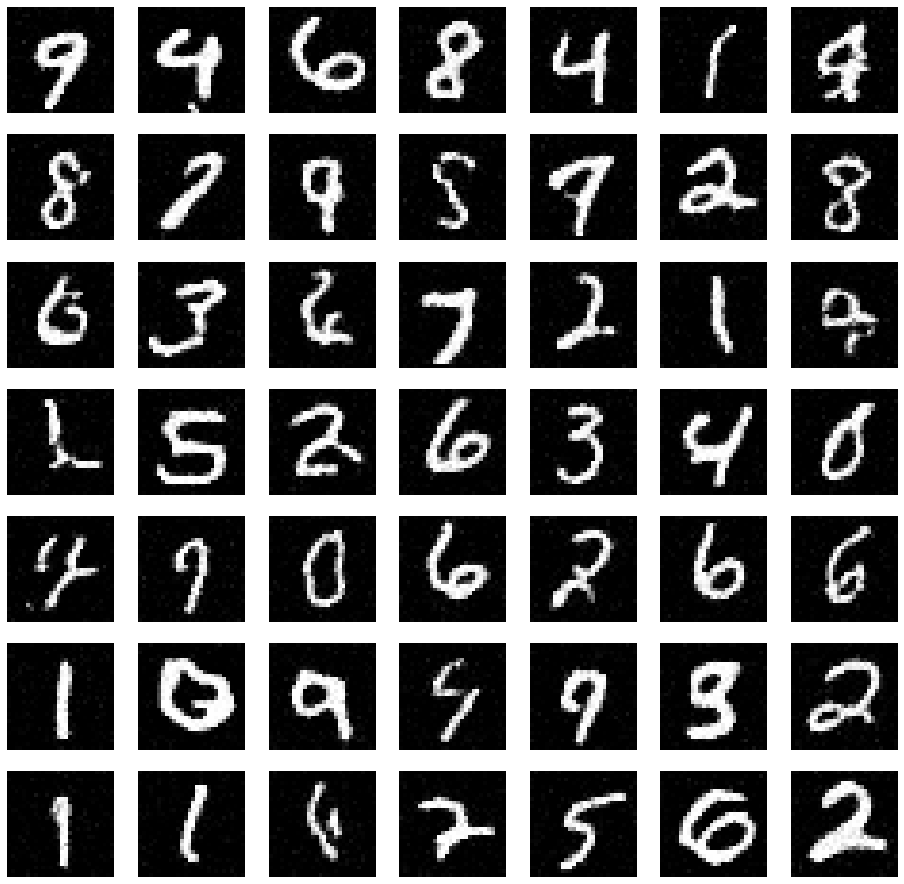

Iteration 100
	 contrastive = 8.143561074510217
	 regularization = 41.51593618094921
Iteration 200
	 contrastive = 9.084312344901264
	 regularization = 46.95578779280186
Iteration 300
	 contrastive = 9.65443742275238
	 regularization = 48.388557344675064
Iteration 400
	 contrastive = 9.622443762607872
	 regularization = 49.16286423802376
Epoch : 17


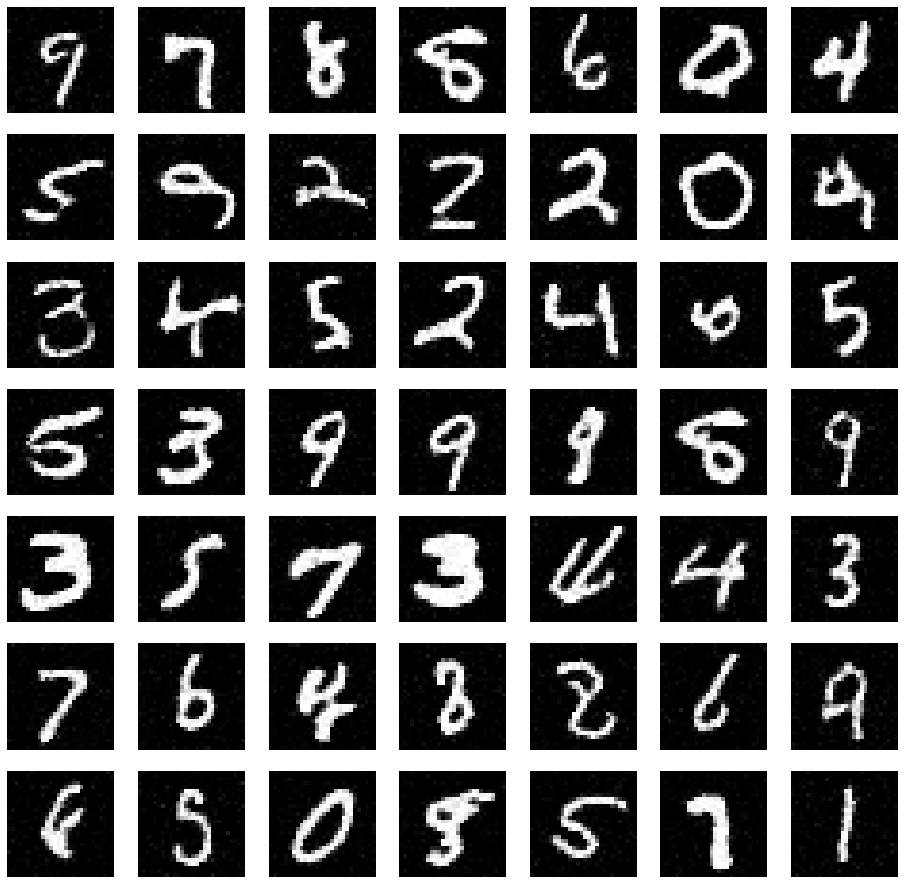

Iteration 100
	 contrastive = 9.747123755514622
	 regularization = 48.72882837057114
Iteration 200
	 contrastive = 8.852102436125278
	 regularization = 44.44730345904827
Iteration 300
	 contrastive = 8.894212049432099
	 regularization = 45.63543216884136
Iteration 400
	 contrastive = 9.089064784348011
	 regularization = 46.658783838152885
Epoch : 18


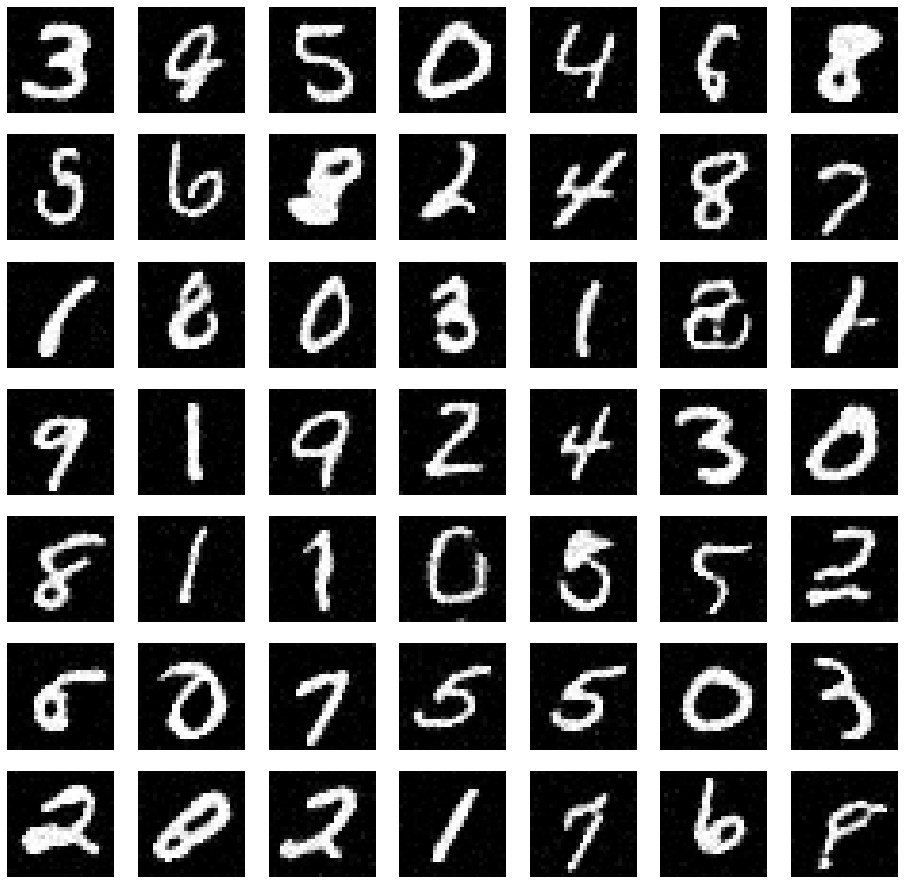

Iteration 100
	 contrastive = 9.368778233416378
	 regularization = 47.523911744356155
Iteration 200
	 contrastive = 8.678936681710184
	 regularization = 44.158960685133934
Iteration 300
	 contrastive = 9.414367304183543
	 regularization = 48.13556128740311
Iteration 400
	 contrastive = 9.73025861941278
	 regularization = 50.05080261826515
Epoch : 19


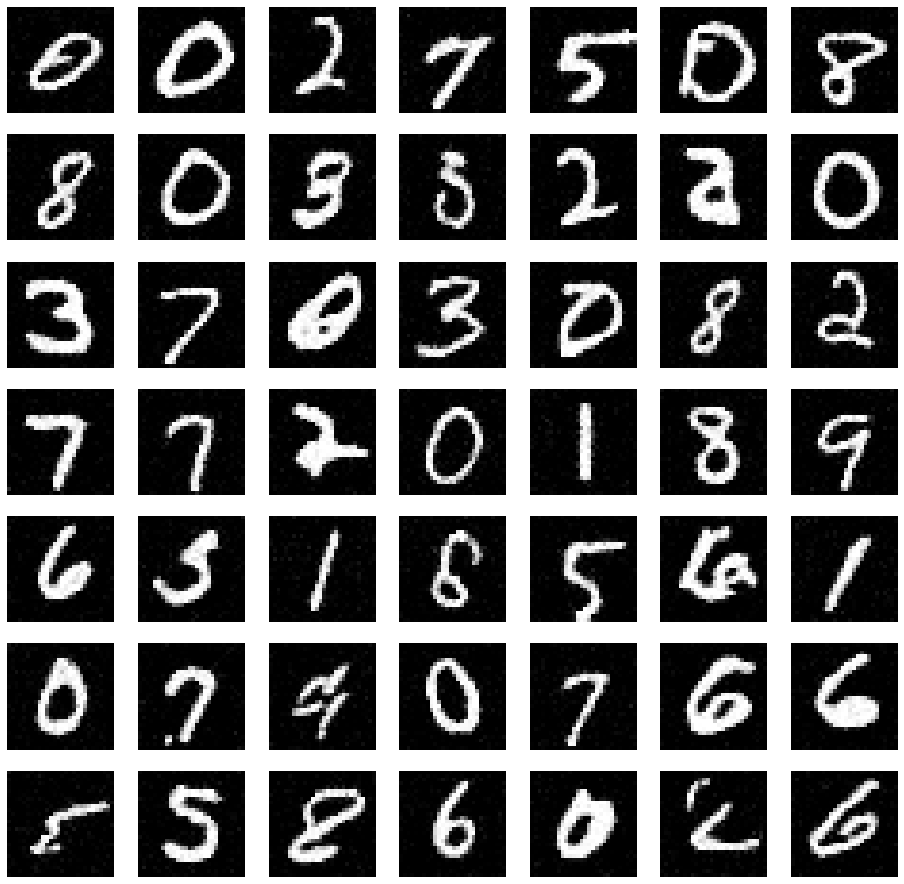

Iteration 100
	 contrastive = 9.050861842930317
	 regularization = 46.29291528463364
Iteration 200
	 contrastive = 8.978500294033438
	 regularization = 45.71036460995674
Iteration 300
	 contrastive = 9.645640422590077
	 regularization = 50.68434028327465
Iteration 400
	 contrastive = 9.287662995047867
	 regularization = 46.40422670543194
Epoch : 20


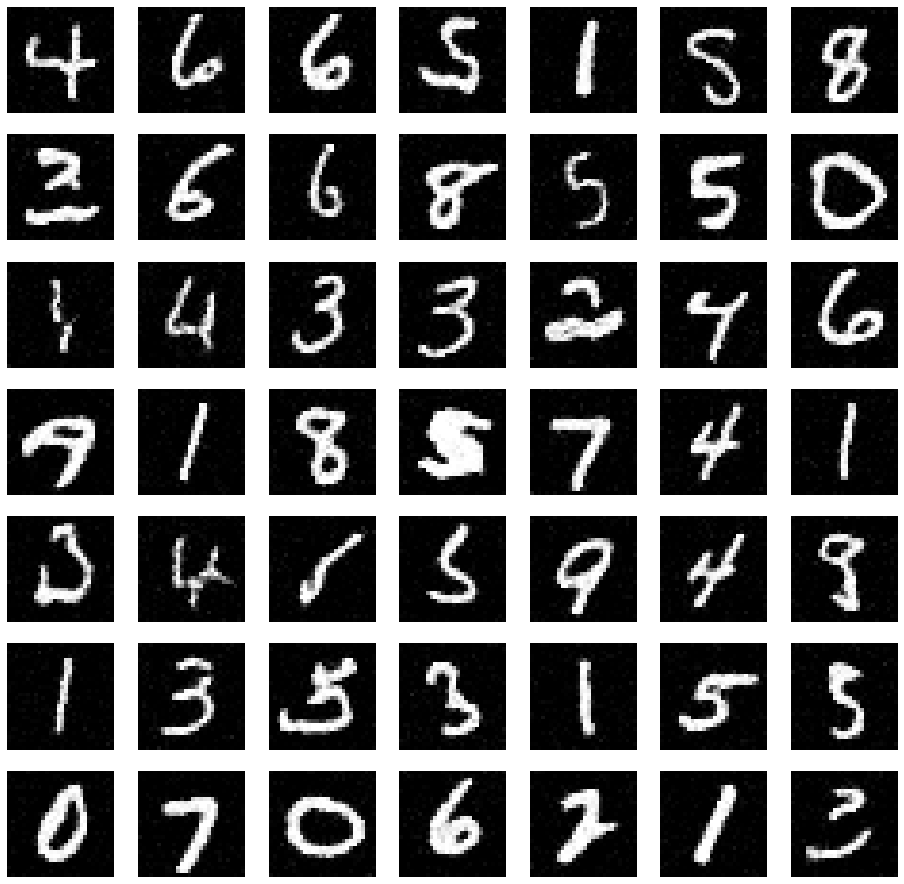

In [159]:
cont_loss = []
reg_loss = []

for ep in range(num_epochs):
  for i, (x, _) in enumerate(data):
    noise = torch.randn(x.shape) * normal_std
    x = torch.clip(x + noise, -1, 1).to(device)
    out_data = E(x)

    y = B.get_samples(E, batch_size=x.shape[0])
    out_dist = E(y)

    contrastive = (out_dist - out_data).mean()
    regression = (out_data ** 2 + out_dist ** 2).mean()
    loss = contrastive + η * regression

    cont_loss.append(-contrastive.item())
    reg_loss.append(regression.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if (i + 1) % 100 == 0:
      print(f"Iteration {i + 1}")
      print(f"\t contrastive = {sum(cont_loss[-100:])}")
      print(f"\t regularization = {sum(reg_loss[-100:])}")
  
  print(f"Epoch : {ep + 1}")
  y = B.get_samples(E, 49, ratio=0.0).detach()
  y = (y + 1) / 2
  y = torch.clip(y, 0, 1)
  y = y.permute((0, 2, 3, 1))
  y = y.cpu().numpy()
  y *= 255
  y = y.astype(np.uint8)

  for i in range(7):
    for j in range(7):
      index = 7 * i + j + 1
      plt.subplot(7, 7, index)
      plt.axis("off")
      plt.imshow(y[index - 1][:, :, 0], cmap="gray")
  
  plt.show()

In [171]:
def q1(train_data):
  """
  train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

  Returns
  - a (# of training iterations, ) numpy array full of contrastive losses on each iteration
  - a (# of training iterations, ) numpy array full of regularization losses on each iteration
  - a (100, 28, 28, 1) numpy array of 100 samples from ebm model
  """
  sample = B.get_samples(E, 100, ratio=0.0).detach()
  sample = (sample + 1) / 2
  sample = torch.clip(sample, 0, 1)
  sample = sample.permute((0, 2, 3, 1))
  sample = sample.cpu().numpy()

  return cont_loss, reg_loss, sample

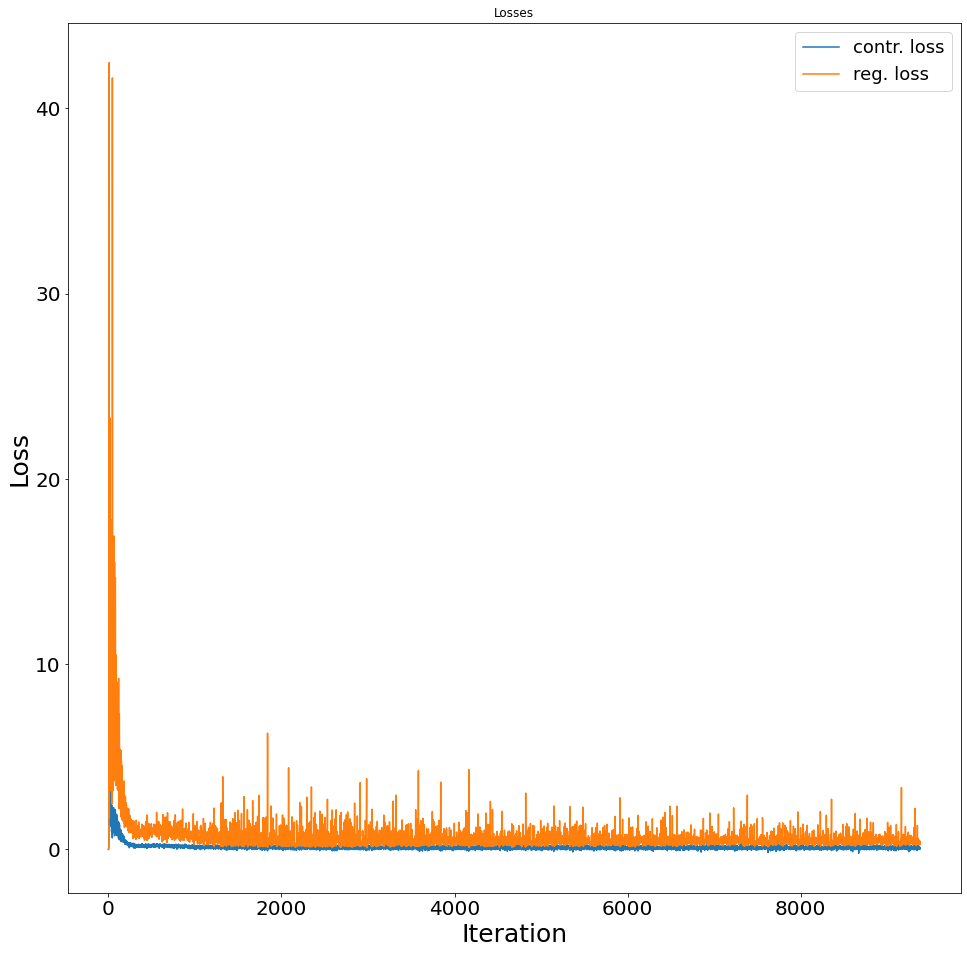

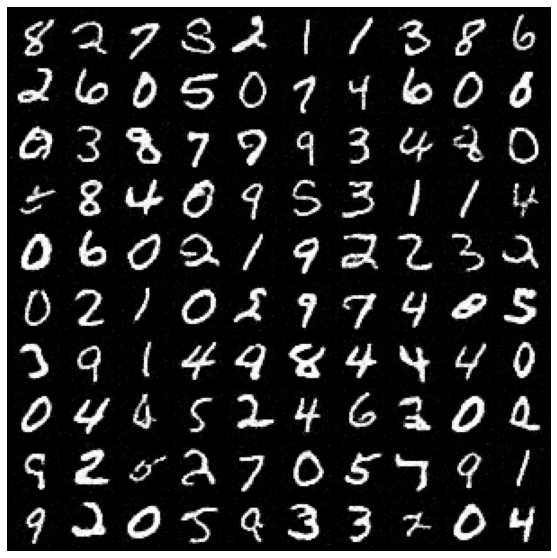

In [172]:
q1_results(q1)

# Question 2: EBM conditional generation

Here we will train EBM jointly with classifier to generate objects conditioned on class labels. ([original paper](https://arxiv.org/pdf/1912.03263.pdf)).

* **Theory**. Here we will work with joint distribution on x (data point) and y (label). We will parametrize probability of the pair as follows

```
p_θ(x, y) = exp(f_θ(x)[y]) / Z(θ)
```
Where `f(x)[y]` is an y-th output of the classifier model and `Z(θ)` is a normalization constant.

We will optimize log-likelihood of train pair:

```
log p(x, y) = log p(x) + log p(y|x)
```

Second term corresponds to normal classification loss and we will optimize it with cross entropy. We will optimize first term via contrastive divergence. The energy of can be from classifire output : `E(x)=-log ∑ exp(f_θ(x)[y])`.

* **Architecture.** We will work with smile dataset and you can use architecture from practice.

* **Hyperparameters**
    * Max buffer size - 8192
    * MCMC step size - 0.1
    * MCMC # step - 500 (during final sampling you can increase it)
    * MCMC noise - N(0, 0.005)
    * Noise to data - None
    * l2 reg weight - 0.1
    * batch_size - 128
    * use Adam with lr=1e-3 and betas=(0, 0.999)
    * you can use exponential scheduler
    * 100 epochs should be enough (~10 minutes on cpu)



**You will provide the following deliverables**


1.   Over the course of training, record loss per batch.
3. 300 samples from your trained EBM. First 100 samples should be generated for label 0, next 100 for label 1, and last 100 for label 2

## Classifier

In [56]:
class Classifier(nn.Module):
  def __init__(self, hid_dim=256):
    super().__init__()
    self.model = nn.Sequential(nn.Linear(2, hid_dim),
                               nn.SiLU(),
                               nn.Linear(hid_dim, hid_dim),
                               nn.SiLU(),
                               nn.Linear(hid_dim, 3))
    
  def forward(self, x):
    return self.model(x)

## Sampling

In [57]:
def MCMC(model, x, steps=100, ε=1e-1, noise_std=5e-2):
  x.requires_grad = True
  grad_output = torch.ones((x.shape[0], 1), device=device)

  for _ in range(steps):
    # get gradient from LogSumExp(model(x))
    g = torch.autograd.grad(torch.logsumexp(model(x), 1).unsqueeze(1), x,
                            grad_outputs=grad_output)[0]
    # add gradient to x
    x = x + g * ε
    
    # get noise
    z = torch.randn(x.shape, device=device) * noise_std
    # add noise to x
    x = x + np.sqrt(2 * ε) * z

  return x.detach()

## Hyperparameters

In [103]:
num_epochs = 160
batch_size = 128
η = 1e-1

## Load data

In [92]:
train_data, train_labels, _, _ = q2_sample_data()

data = torch.tensor(train_data, device=device).float()
labels = torch.tensor(train_labels, device=device).long()

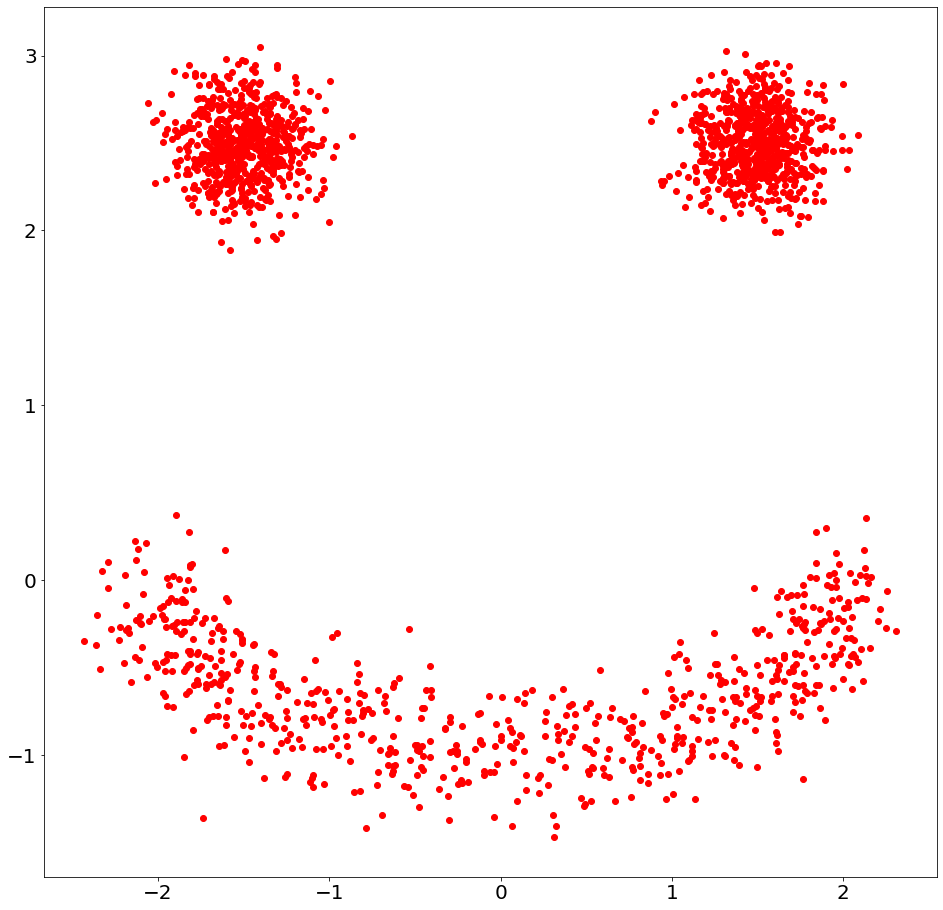

In [93]:
plt.plot(train_data[:, 0], train_data[:, 1], 'ro')
plt.show()

## Define model

In [104]:
from torch.optim import Adam

C = Classifier()
B = Buffer(sample_size=(2,))

opt = Adam(C.parameters(), 1e-3, betas=(0, 0.999))
ces = nn.CrossEntropyLoss()

## Training loop

Epoch : 40
	 contrastive = 4.747170850634575
	 reconstruction = 26.85678458213806
	 classification = 0.04034624854102731


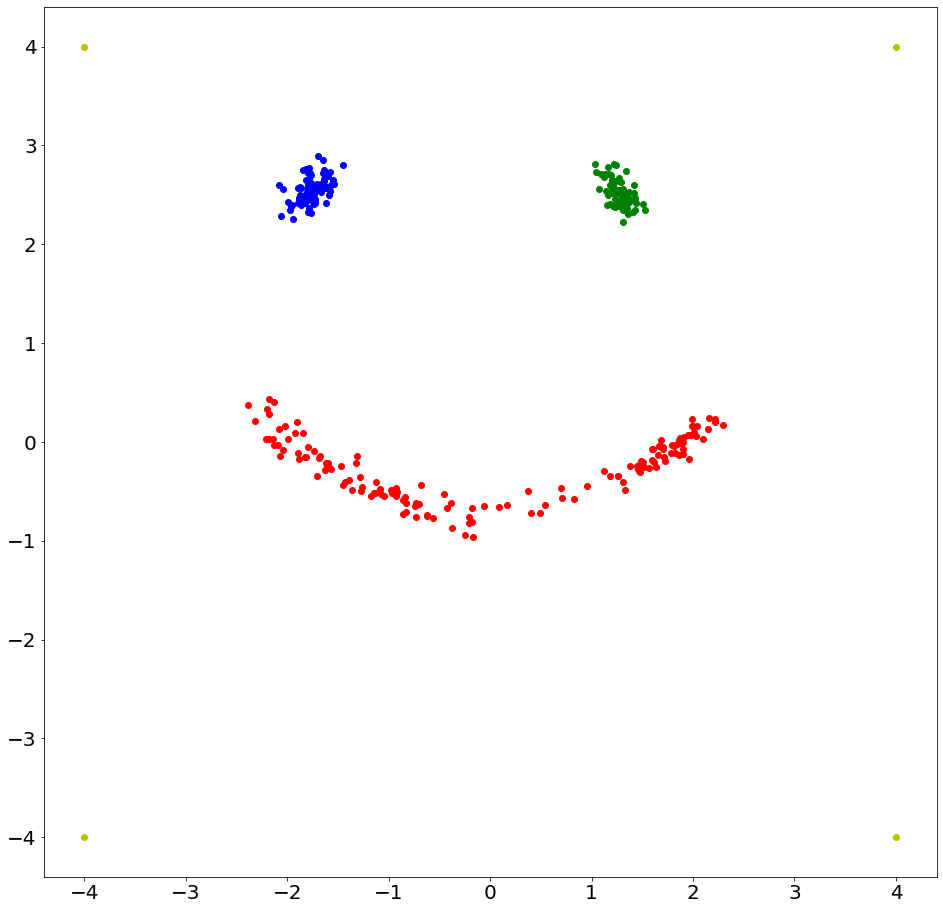

Epoch : 80
	 contrastive = 8.61981874704361
	 reconstruction = 43.855226278305054
	 classification = 0.018637825618498027


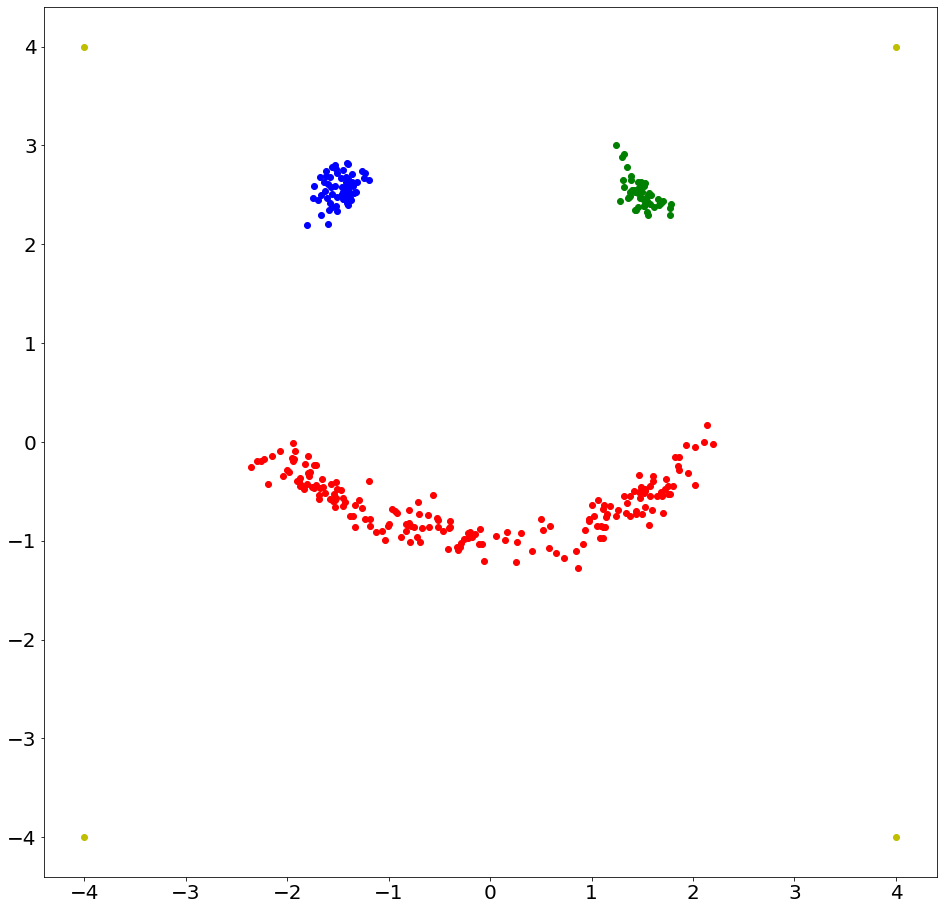

Epoch : 120
	 contrastive = 14.314738601446152
	 reconstruction = 72.06086778640747
	 classification = 0.011383855191525072


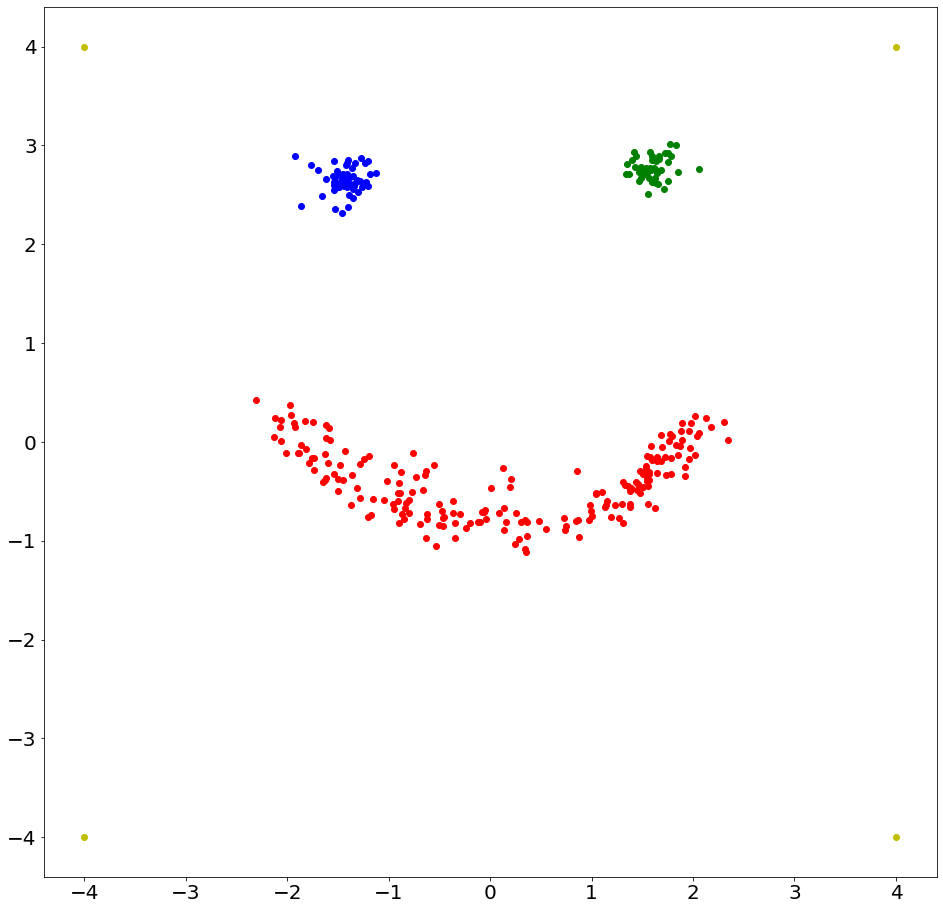

Epoch : 160
	 contrastive = 15.47321480512619
	 reconstruction = 79.46072626113892
	 classification = 0.009167029056698084


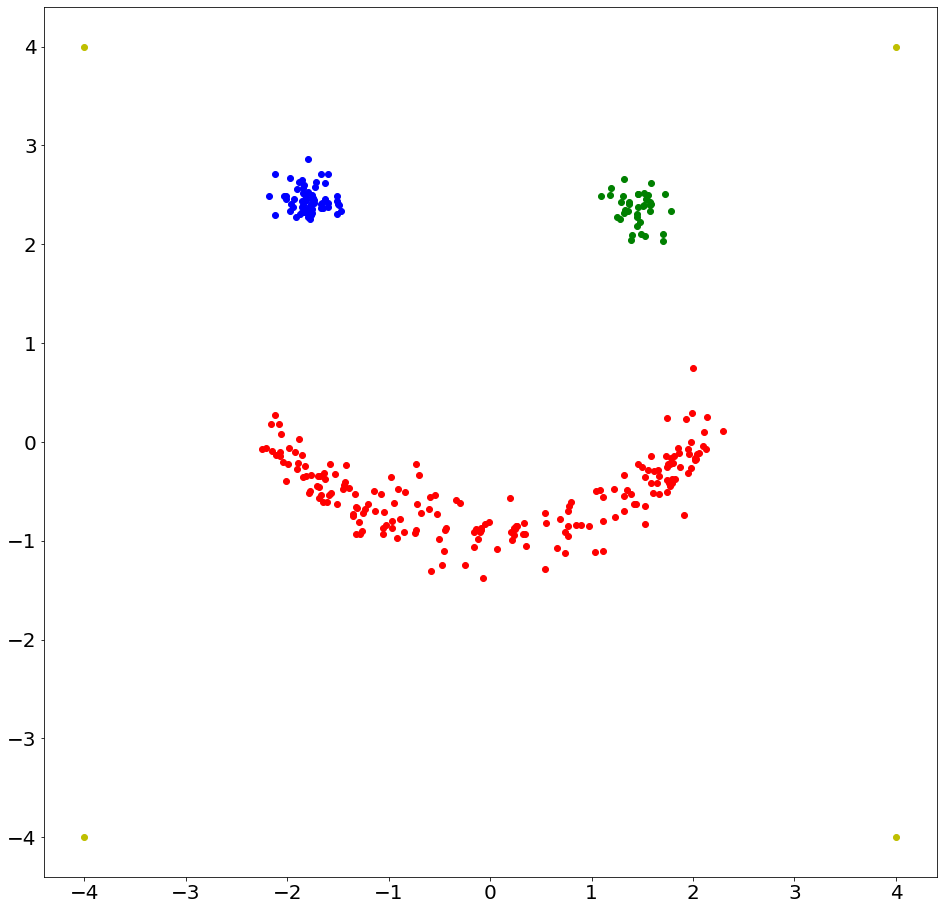

In [105]:
loss_record = []

for epoch in range(num_epochs):
  W, R, L = 0, 0, 0
  data_size = data.shape[0]
  per = np.random.permutation(data_size)
  for i in range(0, data_size, batch_size):
    idx = per[i : i + batch_size]
    x = data[idx]
    out_data = torch.logsumexp(C(x), 1)

    y = B.get_samples(C, batch_size=x.shape[0])
    out_dist = torch.logsumexp(C(y), 1)

    c_loss = (out_dist - out_data).mean()
    r_loss = (out_dist ** 2 + out_data ** 2).mean()
    ces_loss = ces(C(x), labels[idx])
    
    W -= c_loss.item()
    R += r_loss.item()
    L += ces_loss.item()
    
    loss = c_loss + η * r_loss + ces_loss
    loss_record.append(loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
  
  if (epoch + 1) % 40 == 0:
    print(f"Epoch : {epoch + 1}")
    print(f"\t contrastive = {W}")
    print(f"\t reconstruction = {R}")
    print(f"\t classification = {L}")

    v = B.get_samples(C, 300)
    l = torch.argmax(C(v), 1).numpy()

    v = v.numpy()
    plt.plot([-4.0, -4.0, 4.0, 4.0], [-4.0, 4.0, 4.0, -4.0], 'yo')
    color = ['bo', 'go', 'ro']
    for i in range(3):
      plt.plot(v[l == i][:, 0], v[l == i][:, 1], color[i])
    plt.show()

In [106]:
def q2(train_data, train_labels):
    """
    train_data: An (n_train, 2) np.array of binary points
    train_labels: An (n_train, ) np.array labels (3 classes)
    Returns
    - a (# of training iterations, ) numpy array full of losses on each iteration
    - a (300, 2) numpy array of 300 samples from ebm model (0-99 with label 0; 100-199 with label 1; 200-300 with label 2)
    """
    samples = B.get_samples(C, 1000)
    with torch.no_grad():
      l = torch.max(C(samples), 1)

    l = [l[0].numpy(), l[1].numpy()]
    samples = samples.numpy()
    
    S = np.zeros((300, 2))
    for i in range(3):
      T = l[0]
      label_idx = (l[1] == i)
      top = np.argsort(T[label_idx])[-100:]
      S[i * 100 : (i + 1) * 100] = samples[label_idx][top]
      

    return loss_record, S 

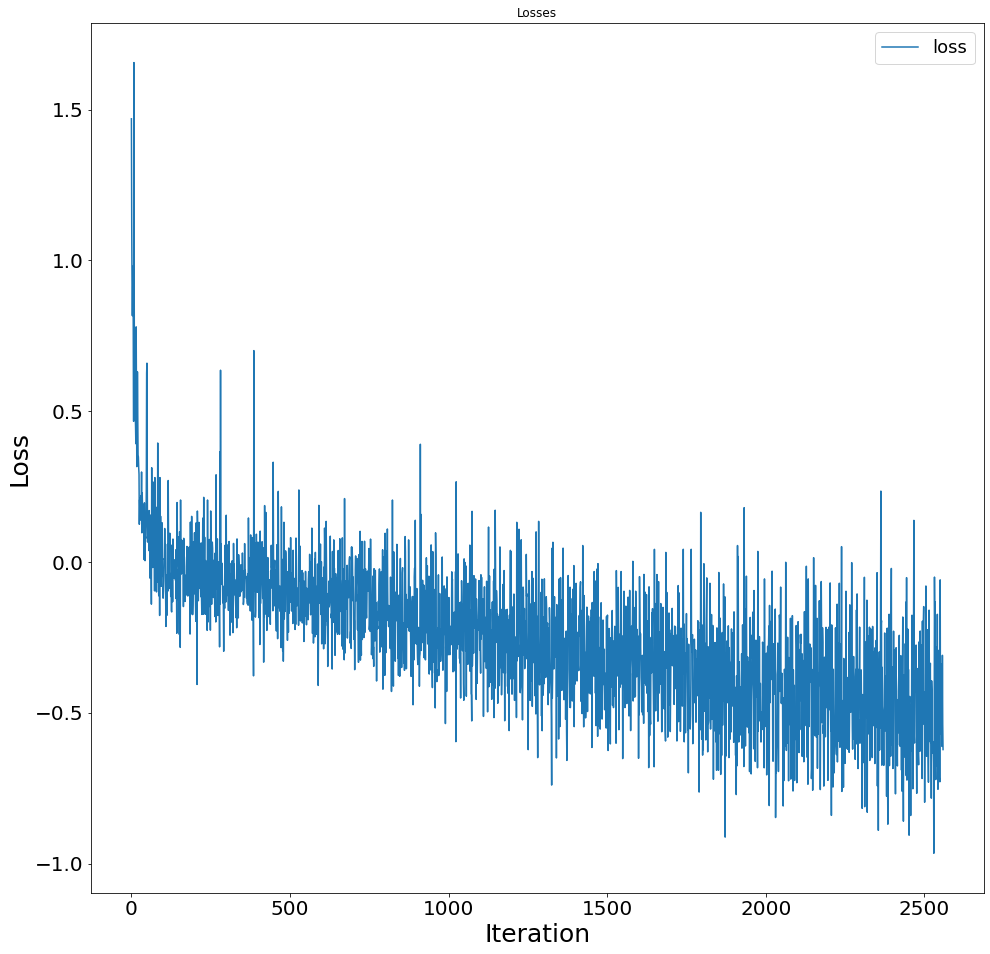

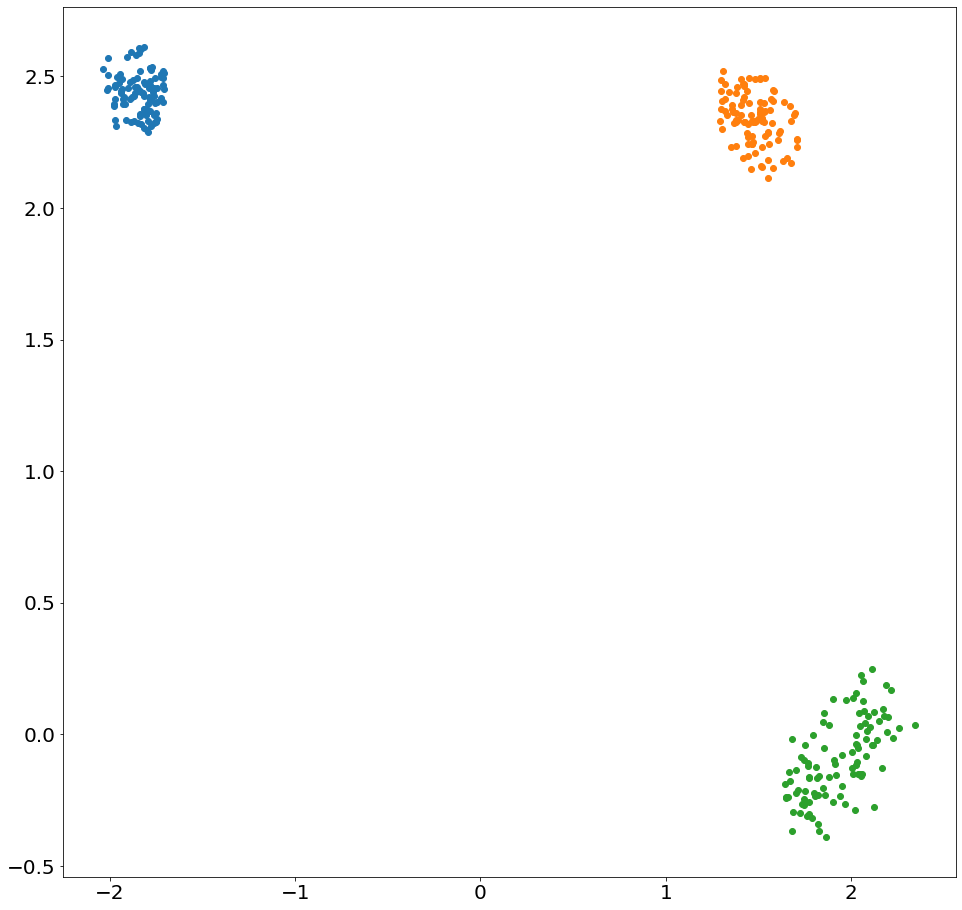

In [107]:
q2_results(q2)

# Bonus : Conditional generation with EBM and classifier.

Here you need to generate points conditioned on class on smile dataset with independently trained ebm and classifier. For generation use MCMC with

```
log p(x|y) ~ log p(x) + log p(y|x)
```

Where first term is `-E(x)` and second is obtained via backprop from trained classifier.

In [ ]:
def b(train_data, train_labels):
    """
    train_data: An (n_train, 2) np.array of binary points
    train_labels: An (n_train, ) np.array labels (3 classes)
    Returns
    - a (# of training iterations, ) numpy array full of losses of classfier on each iteration
    - a (# of training iterations, ) numpy array full of losses of ebm on each iteration
    - a (300, 2) numpy array of 300 samples from ebm model (0-99 with label 0; 100-199 with label 1; 200-300 with label 2)
    """

In [ ]:
b_results(b)